### Embedding dataset

In [2]:
!pip install sentence-transformers tqdm --quiet

In [9]:
import pandas as pd
import numpy as np
import pickle
import argparse
# import torch

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, pairwise_distances

from tqdm import tqdm

In [59]:
!ls ../datasets/*.json

../datasets/final_dataser_filtered-v1.json
../datasets/final_dataset.json
../datasets/final_dataset_processed.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import torch
from sentence_transformers import SentenceTransformer, util

data = data[(1. - data['specificity'].isna()).astype(bool)]
prompts = data.prompt

transformer = SentenceTransformer("all-MiniLM-L6-v2", device='cuda')
embeddings = transformer.encode(prompts.tolist(), convert_to_tensor=True, batch_size=256, show_progress_bar=True)
torch.save(embeddings, 'embeddings.pt')

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

In [135]:
torch.save(embeddings, 'embeddings.pt')
# embeddings = torch.load('embeddings.pt')

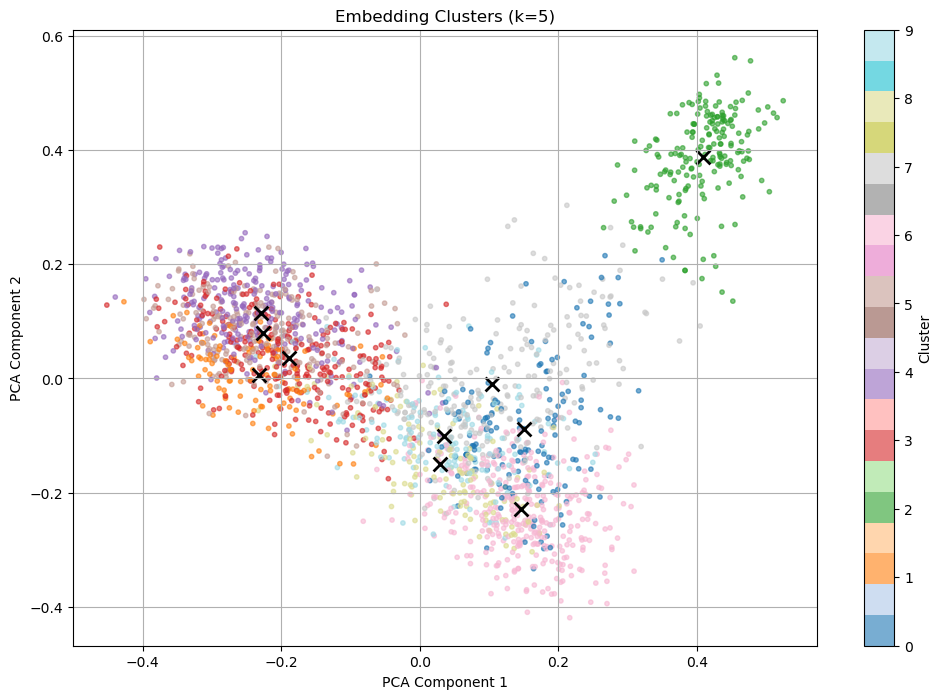

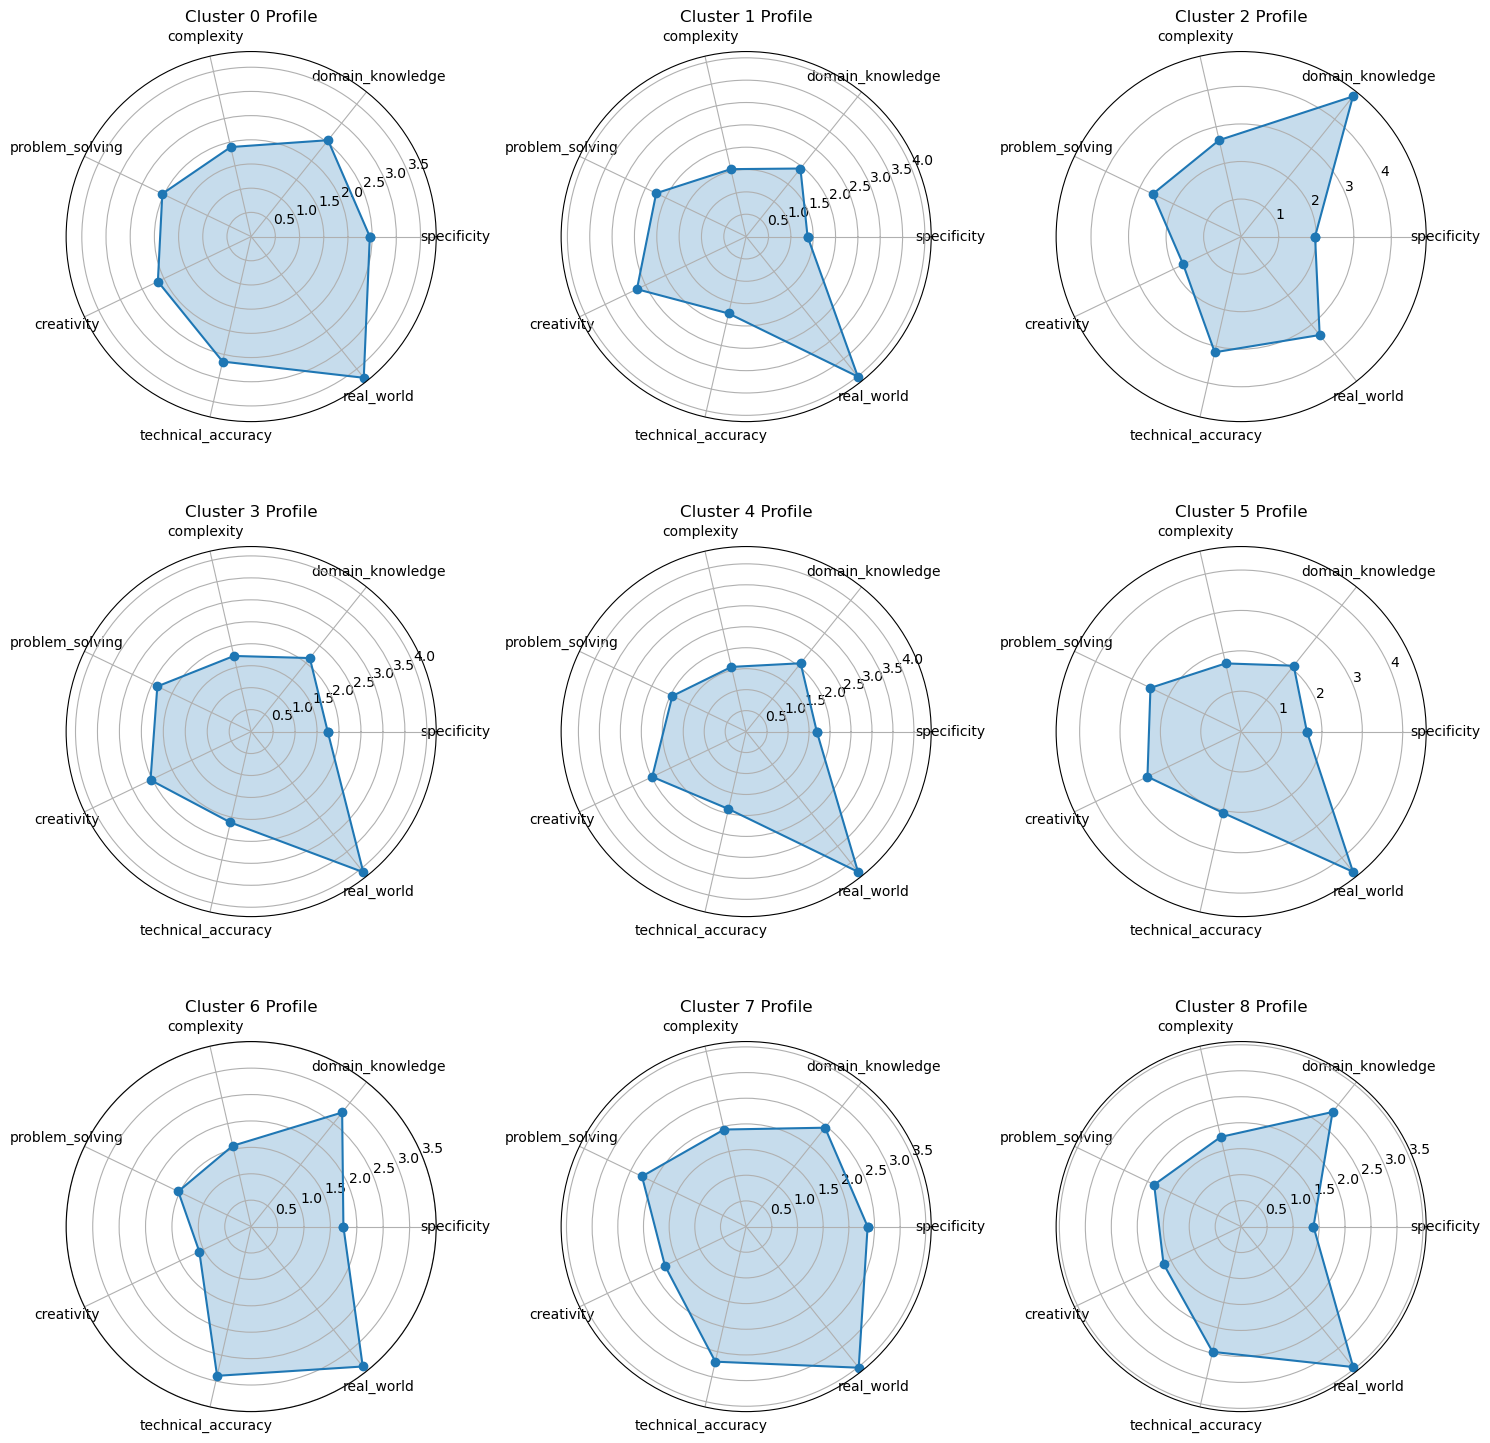

In [ ]:
if torch.is_tensor(embeddings):
    embeddings = embeddings.cpu().numpy()

def find_optimal_clusters(embeddings, max_k=20):
    """Find optimal number of clusters using elbow method"""
    distortions = []
    for k in range(7, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=666)
        kmeans.fit(embeddings)
        distortions.append(kmeans.inertia_)

    deltas = np.diff(distortions)
    elbow = np.argmin(deltas[1:] / deltas[:-1]) + 2
    return min(elbow, 15)

def plot_radar_chart(cluster_profile, ax):
    aspects = list(cluster_profile['aspect_means'].keys())
    values = list(cluster_profile['aspect_means'].values())
    
    angles = np.linspace(0, 2 * np.pi, len(aspects), endpoint=False)
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    
    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, values, marker='o')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(aspects)
    ax.set_title(f"Cluster {cluster_profile['cluster']} Profile")


# optimal_k = find_optimal_clusters(embeddings)
# It really gave random shit

optimal_k = 7
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# 4. Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=clusters,
    cmap='tab20',
    alpha=0.6,
    s=10
)

# Add cluster centers
centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(
    centers[:, 0],
    centers[:, 1],
    c='black',
    marker='x',
    s=100,
    linewidths=2
)

plt.colorbar(scatter, label='Cluster')
plt.title(f'Embedding Clusters (k={optimal_k})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

aspect_scores = data[['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
       'creativity', 'technical_accuracy', 'real_world']].copy()
def get_cluster_profiles(clusters, aspect_scores):
    cluster_profiles = []
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        profile = {
            'cluster': cluster_id,
            'size': mask.sum(),
            'aspect_means': aspect_scores[mask].mean().to_dict(),
            'aspect_stds': aspect_scores[mask].std().to_dict()
        }
        cluster_profiles.append(profile)
    return pd.DataFrame(cluster_profiles)
cluster_profiles = get_cluster_profiles(clusters, aspect_scores)

fig, axes = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'polar': True})
for ax, profile in zip(axes.flatten(), cluster_profiles.to_dict('records')):
    plot_radar_chart(profile, ax)
plt.tight_layout()
plt.show()

In [97]:
def get_cluster_samples(texts, clusters, n_samples=3):
    """Get representative samples from each cluster"""
    df = pd.DataFrame({'text': texts, 'cluster': clusters})
    samples = []
    
    for cluster in sorted(df['cluster'].unique()):
        cluster_texts = df[df['cluster'] == cluster]['text'].tolist()
        cluster_embeddings = embeddings[df['cluster'] == cluster]
        
        # Find closest to centroid
        centroid = kmeans.cluster_centers_[cluster]
        closest_text_pairs = sorted(zip(min(pairwise_distances(
            centroid.reshape(1, -1), 
            cluster_embeddings
        )), cluster_texts))[:n_samples]
        #print(closest_text_pairs)
        
        samples.append({
            'cluster': cluster,
            'size': len(cluster_texts),
            'examples': [t[1] for t in closest_text_pairs]
        })
    
    return samples

cluster_samples = get_cluster_samples(prompts, clusters, 5)

for sample in cluster_samples:
    print(f"\nCluster {sample['cluster']} ({sample['size']} items):")
    for i, example in enumerate(sample['examples']):
        print(f"{i}. {example[:200]}...")


Cluster 0 (157 items):
0. Tengo sed. ¿Qué puedo hacer?...
1. ¿Qué es Excel?...
2. Soy una persona de la tercera edad, ¿Deberia dormir al menos 8 horas diarias?...
3. ¿Cómo puedo mejorar mi salud física?...
4. ¿Cuantos habitantes tiene Zaragoza?...

Cluster 1 (115 items):
0. To hide device wires in homemade nightstand....
1. To clean a dusty  carpet....
2. To protect your teeth....
3. To keep glasses from steaming up....
4. To easily remove bags from a trash can....

Cluster 2 (192 items):
0. You are given a paper:
Title: BERTRAM: Improved Word Embeddings Have Big Impact on Contextualized Model Performance
Abstract: Pretraining deep contextualized representations using an unsupervised lang...
1. You are given a paper:
Title: Massive vs. Curated Word Embeddings for Low-Resourced Languages. The Case of Yor\`ub\'a and Twi
Abstract: The success of several architectures to learn semantic represent...
2. You are given a paper:
Title: Semi-supervised sequence tagging with bidirectional langua

In [120]:
def stratified_diverse_sampling(embeddings, clusters, samples_per_cluster=30, total_samples=300):
    """
    Sample embeddings ensuring:
    - Balanced representation from each cluster
    - Maximum diversity within clusters
    """
    # Convert to numpy if needed
    if torch.is_tensor(embeddings):
        embeddings = embeddings.cpu().numpy()
    
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)
    
    # Calculate adjusted samples per cluster (handle small clusters)
    cluster_counts = np.bincount(clusters)
    adjusted_samples = np.minimum(samples_per_cluster, cluster_counts)
    remaining_samples = total_samples - adjusted_samples.sum()
    
    # Distribute remaining samples proportionally
    if remaining_samples > 0:
        proportions = cluster_counts / cluster_counts.sum()
        extra_samples = (proportions * remaining_samples).astype(int)
        adjusted_samples += extra_samples
    
    selected_indices = []
    
    for cluster in tqdm(unique_clusters, desc="Sampling clusters"):
        cluster_mask = (clusters == cluster)
        cluster_embeddings = embeddings[cluster_mask]
        cluster_indices = np.where(cluster_mask)[0]
        n_samples = adjusted_samples[cluster]
        
        if n_samples == 0:
            continue
            
        # Initialize with farthest pair
        distances = pairwise_distances(cluster_embeddings)
        farthest_pair = np.unravel_index(np.argmax(distances), distances.shape)
        sampled_indices = list(farthest_pair)
        
        # Greedy selection of most distant points
        while len(sampled_indices) < n_samples:
            # Get distances to already selected points
            min_distances = distances[:, sampled_indices].min(axis=1)
            # Select the point with maximum minimum distance
            new_index = np.argmax(min_distances)
            sampled_indices.append(new_index)
        
        # Map back to original indices
        selected_indices.extend(cluster_indices[sampled_indices[:n_samples]])
    
    return np.array(selected_indices)

sampled_indices = stratified_diverse_sampling(embeddings, clusters, 30, 500)
sampled_embeddings = embeddings[sampled_indices]
sampled_texts = [prompts[i] for i in sampled_indices]
sampled_clusters = clusters[sampled_indices]

print("Cluster distribution in sample:")
print(pd.Series(sampled_clusters).value_counts().sort_index())

data["cluster"] = clusters
data["is_sampled"] = False
data.loc[sampled_indices, "is_sampled"] = True

Sampling clusters: 100%|███████████████████████| 10/10 [00:00<00:00, 189.34it/s]

Cluster distribution in sample:
0    65
1    48
2    55
3    48
4    41
5    50
6    54
7    50
8    43
9    41
Name: count, dtype: int64


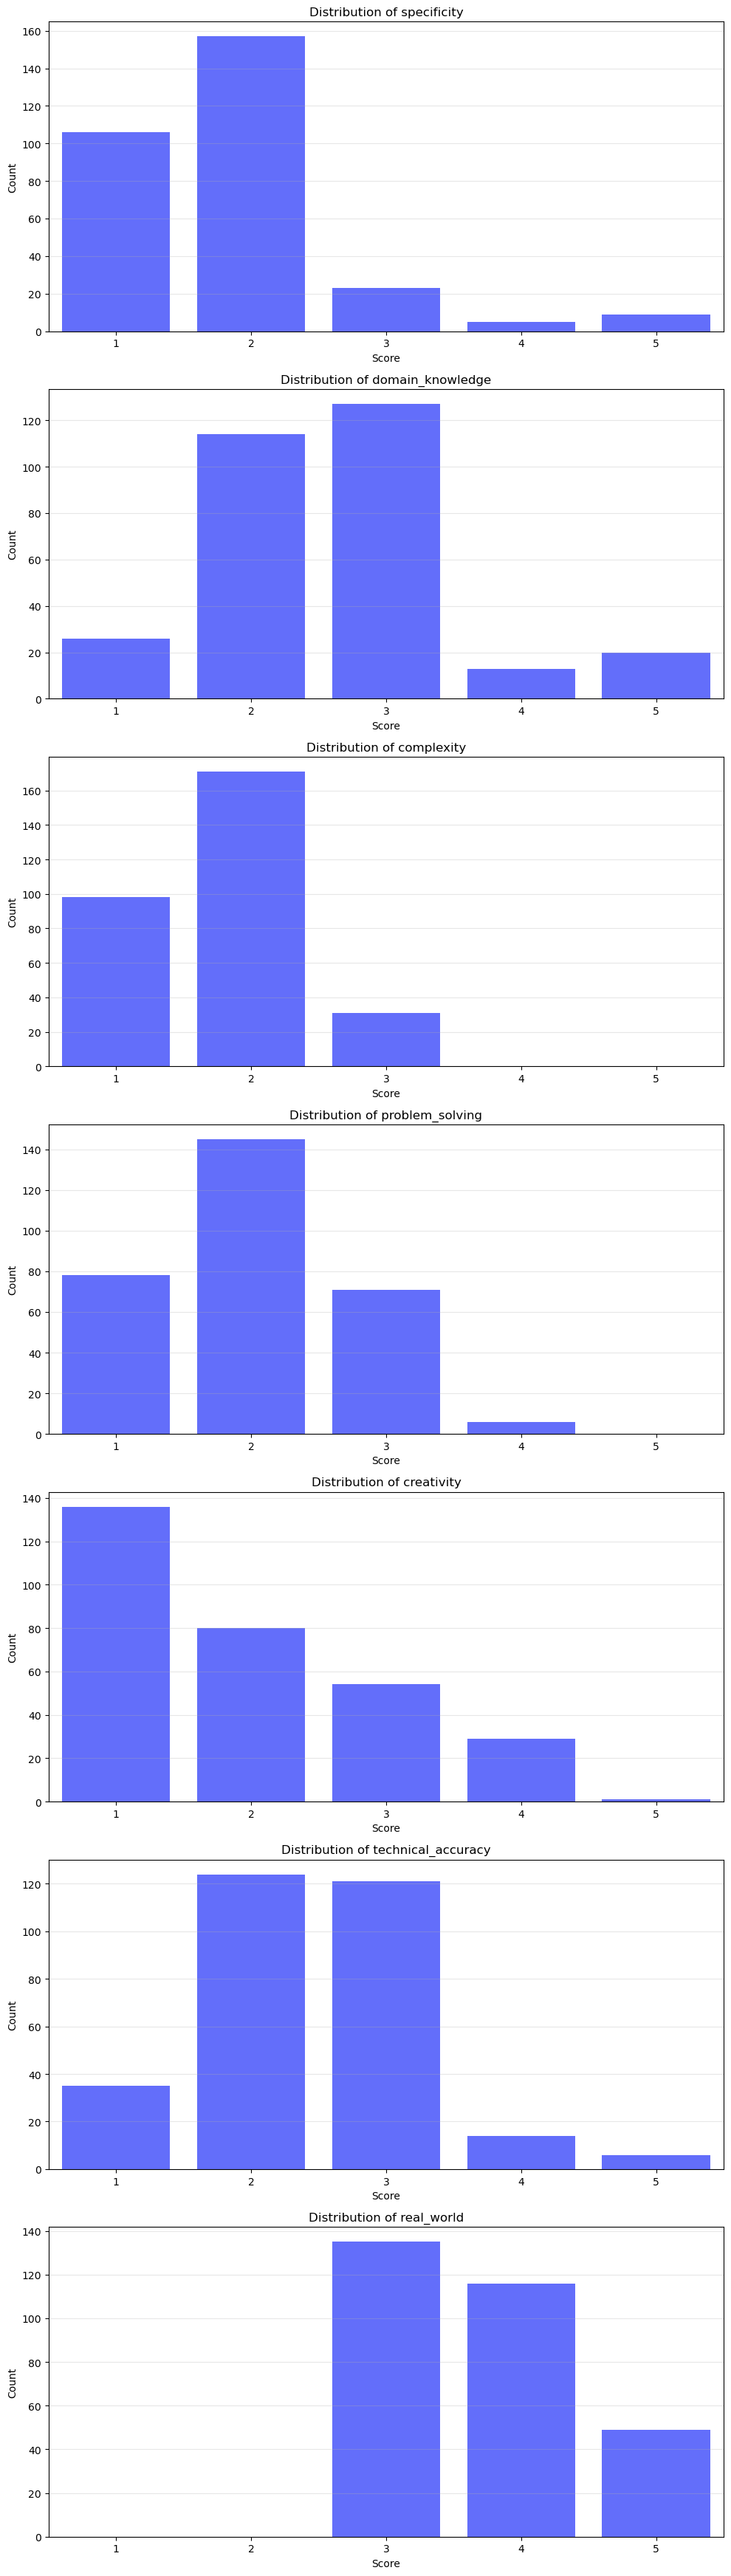

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# List of all aspects to plot
aspects = ['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
           'creativity', 'technical_accuracy', 'real_world']

# Create figure with subplots - one row per aspect
fig, axes = plt.subplots(len(aspects), 1, figsize=(10, 5*len(aspects)))

# If only one aspect, axes won't be array - make it consistent
if len(aspects) == 1:
    axes = [axes]

# Plot each aspect's distribution
for ax, aspect in zip(axes, aspects):
    # Get data for sampled points only
    values = data[data["is_sampled"]][aspect]
    
    # Create histogram
    counts, bins = np.histogram(values, bins=5, range=(1, 6))
    ax.bar(bins[:-1], counts, width=0.8, align='center', color='#636EFA')
    
    # Customize plot
    ax.set_title(f'Distribution of {aspect}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlim(0.5, 5.5)
    ax.grid(axis='y', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

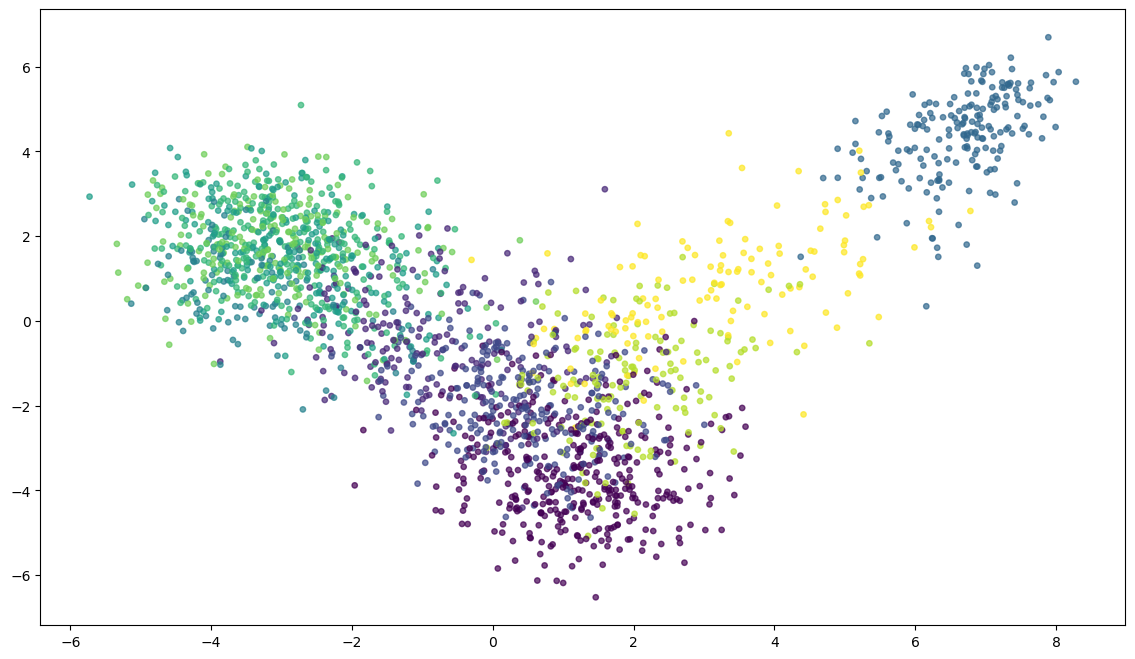

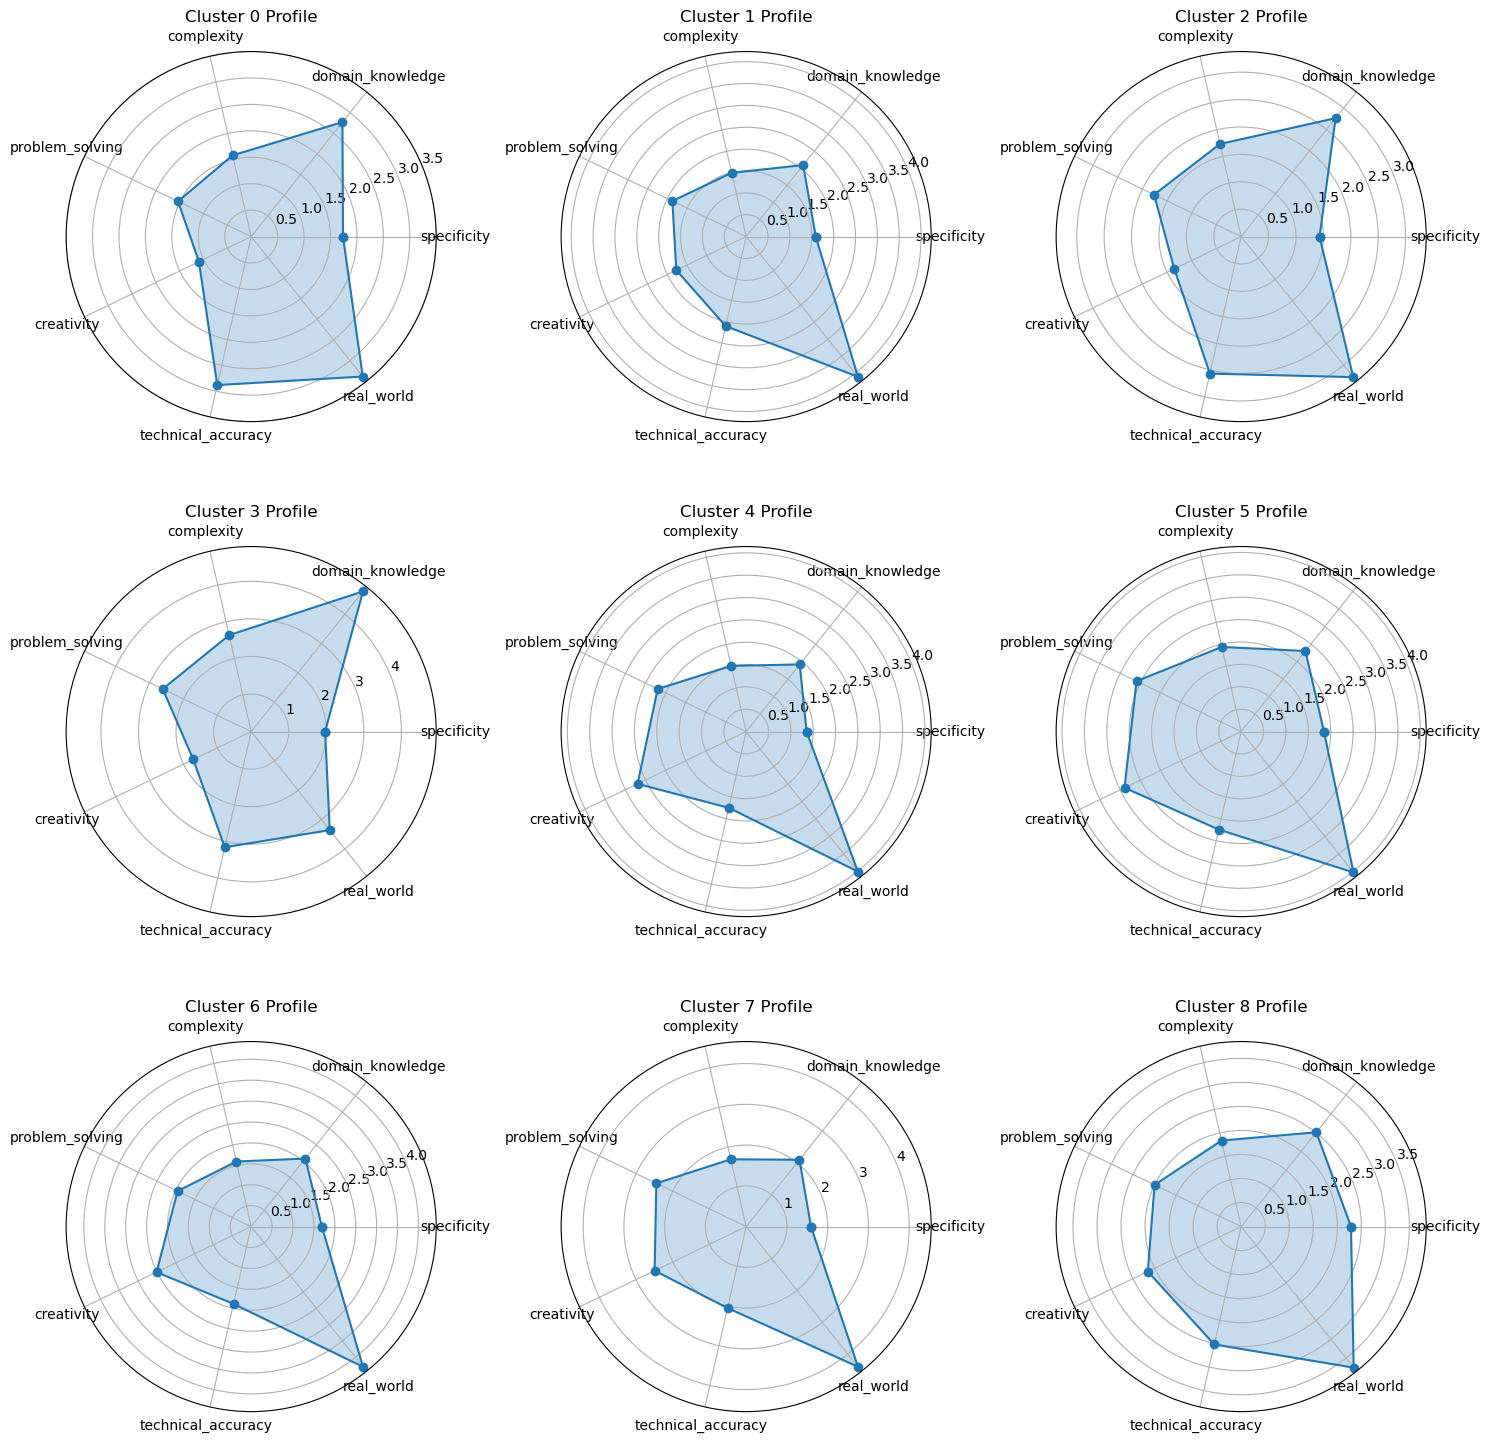

In [108]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 1. Normalize aspect scores
aspect_weights = {
    'specificity': 1.2,
    'domain_knowledge': 1.1,
    'complexity': 4.0,
    'problem_solving': 3.0,
    'creativity': 3.0,
    'technical_accuracy': 1.3,
    'real_world': 0.7
}

scaler = StandardScaler()
aspect_scores_normalized = scaler.fit_transform(aspect_scores[list(aspect_weights.keys())])

# 2. Apply weights to normalized aspects
weighted_aspects = aspect_scores_normalized * np.array(list(aspect_weights.values()))

# 3. Combine with embeddings (adjust alpha for balance)
alpha = 0.3  # Weight between embeddings (1-alpha) and aspects (alpha)
combined_features = np.hstack([
    (1 - alpha) * StandardScaler().fit_transform(embeddings),
    alpha * weighted_aspects
])

def find_optimal_k(features, max_k=15):
    best_k = 2
    best_score = -1
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(features)
        score = silhouette_score(features, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

# optimal_k = find_optimal_k(combined_features)
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
clusters = kmeans.fit_predict(combined_features)

# 5. Visualization with PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(combined_features)

plt.figure(figsize=(14, 8))
scatter = plt.scatter(
    reduced_features[:, 0],
    reduced_features[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.7,
    s=15
)

# 6. Cluster analysis with aspect profiles
def get_cluster_profiles(clusters, aspect_scores):
    cluster_profiles = []
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        profile = {
            'cluster': cluster_id,
            'size': mask.sum(),
            'aspect_means': aspect_scores[mask].mean().to_dict(),
            'aspect_stds': aspect_scores[mask].std().to_dict()
        }
        cluster_profiles.append(profile)
    return pd.DataFrame(cluster_profiles)

cluster_profiles = get_cluster_profiles(clusters, aspect_scores)

def get_enhanced_samples(texts, clusters, aspect_scores, n_samples=3):
    results = []
    for cluster_id in np.unique(clusters):
        mask = clusters == cluster_id
        cluster_texts = texts[mask]
        cluster_aspects = aspect_scores[mask]
        
        # Get closest to centroid
        centroid = kmeans.cluster_centers_[cluster_id]
        distances = np.linalg.norm(combined_features[mask] - centroid, axis=1)
        closest_idx = np.argsort(distances)[:n_samples]
        
        # Get most distinctive by aspects
        aspect_distinctive_idx = cluster_aspects.std(axis=1).argsort()[-n_samples:]
        
        samples = list(set(closest_idx.tolist() + aspect_distinctive_idx.tolist()))[:n_samples]
        
        results.append({
            'cluster': cluster_id,
            'size': mask.sum(),
            'aspect_profile': cluster_profiles[cluster_profiles['cluster'] == cluster_id]['aspect_means'].iloc[0],
            'examples': [cluster_texts[i] for i in samples]
        })
    return results

cluster_samples = get_enhanced_samples(np.array(prompts), clusters, aspect_scores)

# 8. Visualize clusters with aspect radar plots
def plot_radar_chart(cluster_profile, ax):
    aspects = list(cluster_profile['aspect_means'].keys())
    values = list(cluster_profile['aspect_means'].values())
    
    angles = np.linspace(0, 2 * np.pi, len(aspects), endpoint=False)
    values = np.concatenate((values, [values[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    
    ax.fill(angles, values, alpha=0.25)
    ax.plot(angles, values, marker='o')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(aspects)
    ax.set_title(f"Cluster {cluster_profile['cluster']} Profile")

fig, axes = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'polar': True})
for ax, profile in zip(axes.flatten(), cluster_profiles.to_dict('records')):
    plot_radar_chart(profile, ax)
plt.tight_layout()
plt.show()

In [127]:
def stratified_diverse_sampling(embeddings, clusters, samples_per_cluster=30, total_samples=300):
    """
    Sample embeddings ensuring:
    - Balanced representation from each cluster
    - Maximum diversity within clusters
    """
    # Convert to numpy if needed
    if torch.is_tensor(embeddings):
        embeddings = embeddings.cpu().numpy()
    
    unique_clusters = np.unique(clusters)
    n_clusters = len(unique_clusters)
    
    # Calculate adjusted samples per cluster (handle small clusters)
    cluster_counts = np.bincount(clusters)
    adjusted_samples = np.minimum(samples_per_cluster, cluster_counts)
    remaining_samples = total_samples - adjusted_samples.sum()
    
    # Distribute remaining samples proportionally
    if remaining_samples > 0:
        proportions = cluster_counts / cluster_counts.sum()
        extra_samples = (proportions * remaining_samples).astype(int)
        adjusted_samples += extra_samples
    
    selected_indices = []
    
    for cluster in tqdm(unique_clusters, desc="Sampling clusters"):
        cluster_mask = (clusters == cluster)
        cluster_embeddings = embeddings[cluster_mask]
        cluster_indices = np.where(cluster_mask)[0]
        n_samples = adjusted_samples[cluster]
        
        if n_samples == 0:
            continue
            
        # Initialize with farthest pair
        distances = pairwise_distances(cluster_embeddings)
        farthest_pair = np.unravel_index(np.argmax(distances), distances.shape)
        sampled_indices = list(farthest_pair)
        
        # Greedy selection of most distant points
        while len(sampled_indices) < n_samples:
            # Get distances to already selected points
            min_distances = distances[:, sampled_indices].min(axis=1)
            # Select the point with maximum minimum distance
            new_index = np.argmax(min_distances)
            sampled_indices.append(new_index)
        
        # Map back to original indices
        selected_indices.extend(cluster_indices[sampled_indices[:n_samples]])
    
    return np.array(selected_indices)

In [125]:
sampled_indices = stratified_diverse_sampling(embeddings, clusters, 30, 400)
sampled_embeddings = embeddings[sampled_indices]
sampled_texts = [prompts[i] for i in sampled_indices]
sampled_clusters = clusters[sampled_indices]
data["cluster"] = clusters
data["is_sampled"] = False
data.loc[sampled_indices, "is_sampled"] = True
topic_mapping = {
    # STEM Fields (~90 items)
    'biology': 'STEM',
    'engineering': 'STEM',
    'programming': 'STEM',
    'physics': 'STEM',
    'math': 'STEM',
    'chemistry': 'STEM',
    'science': 'STEM',
    
    # Food & Home (~90 items)
    'cooking': 'Food & Home',
    'recipes/cooking': 'Food & Home',
    'nutrition': 'Food & Home',
    'crafts': 'Food & Home',
    'instructions': 'Food & Home',
    
    # Arts & Literature (~80 items)
    'creative_writing': 'Arts & Literature',
    'literature': 'Arts & Literature',
    'translation': 'Arts & Literature',
    'entertainment': 'Arts & Literature',
    
    # Social Sciences (~80 items)
    'economy': 'Social Sciences',
    'politics': 'Social Sciences',
    'history': 'Social Sciences',
    'philosophy': 'Social Sciences',
    'education': 'Social Sciences',
    
    # Lifestyle (~80 items)
    'life_advice': 'Lifestyle',
    'health': 'Lifestyle',
    'dialogue': 'Lifestyle',
    'sports': 'Lifestyle',
    
    # Research & Technical (~80 items)
    'research': 'Research & Technical',
    'other': 'Research & Technical'
}

data['general_field'] = data['topic'].map(topic_mapping)
print(data[data["is_sampled"]]['general_field'].value_counts())
print(data[data["is_sampled"]]['topic'].value_counts())

Sampling clusters: 100%|███████████████████████| 10/10 [00:00<00:00, 265.53it/s]

general_field
STEM                    99
Food & Home             75
Research & Technical    74
Arts & Literature       59
Lifestyle               54
Social Sciences         34
Name: count, dtype: int64
topic
cooking             71
life_advice         50
entertainment       46
research            41
other               33
biology             28
engineering         24
history             17
physics             17
programming         16
politics             7
economy              7
chemistry            7
math                 6
translation          5
creative_writing     4
literature           4
education            2
sports               2
recipes/cooking      1
instructions         1
crafts               1
nutrition            1
dialogue             1
health               1
philosophy           1
science              1
Name: count, dtype: int64


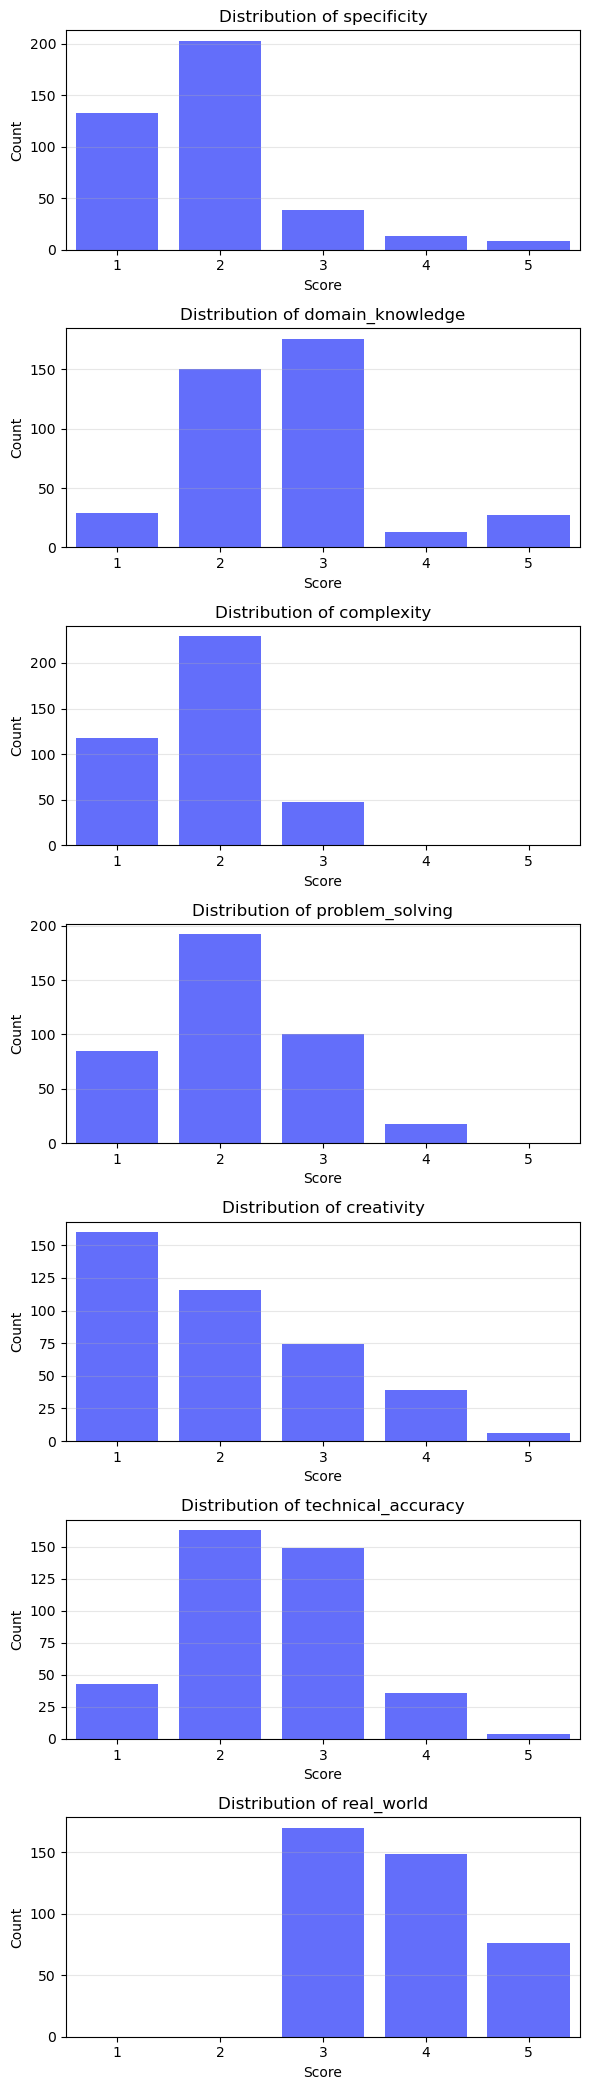

In [126]:
aspects = ['specificity', 'domain_knowledge', 'complexity', 'problem_solving',
           'creativity', 'technical_accuracy', 'real_world']

# Create figure with subplots - one row per aspect
fig, axes = plt.subplots(len(aspects), 1, figsize=(6, 3*len(aspects)))

# If only one aspect, axes won't be array - make it consistent
if len(aspects) == 1:
    axes = [axes]

# Plot each aspect's distribution
for ax, aspect in zip(axes, aspects):
    # Get data for sampled points only
    values = data[data["is_sampled"]][aspect]
    
    # Create histogram
    counts, bins = np.histogram(values, bins=5, range=(1, 6))
    ax.bar(bins[:-1], counts, width=0.8, align='center', color='#636EFA')
    
    # Customize plot
    ax.set_title(f'Distribution of {aspect}')
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_xlim(0.5, 5.5)
    ax.grid(axis='y', alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [129]:
from textwrap import shorten

def format_text(text, max_length=400):
    """Shorten text and add ellipsis if needed"""
    if pd.isna(text):
        return "None"
    return shorten(str(text), width=max_length, placeholder="...")

def print_sampled_prompt_answer_pairs(df):
    top_df = df.head(10)

    if top_df.empty:
        print(f"\n🔍 No top entries found for {column} (score 5)")
        return
    print(f"\n{'='*80}")
    print(f"🌟 SAMPLED PROMPTS")
    print(f"{'='*80}\n")
    
    for idx, row in top_df.iterrows():
        output = {
            'Metadata': {
                'Tag': row.get('tag', 'None'),
                'Source': row.get('source', 'None'),
                'Meta Info': format_text(row.get('meta_info')), 
            },
            'Prompt': format_text(row['prompt']),
            'Answers': {
                'Default': format_text(row.get('default_answer')),
                'Model': format_text(row.get('model_answer')),
                # 'Reference': format_text(row.get('answer'))
            },
        }

        print(f"📌 Entry #{idx}")
        print(f"🏷  Tag: {output['Metadata']['Tag']}")
        print(f"📚 Source: {output['Metadata']['Source']}")
        print(f"ℹ️  Meta: {output['Metadata']['Meta Info']}\n")
        
        print(f"❓ PROMPT:\n{output['Prompt']}\n")
        print("💬 ANSWERS:")
        print(f"• Default: {output['Answers']['Default']}")
        print(f"• Model: {output['Answers']['Model']}")
        print(f"{'-'*60}\n")

print_sampled_prompt_answer_pairs(data[data["is_sampled"]])


🌟 SAMPLED PROMPTS

📌 Entry #0
🏷  Tag: multiple_choice
📚 Source: allenai/ai2_arc
ℹ️  Meta: {'id_in_dataset': 'OHAT_2009_5_9'}

❓ PROMPT:
Earthworms live underground in the soil. As they move through the soil, they create tunnels. The tunnels help improve the soil. Plants grow better in soil that has earthworms. Which statement explains how earthworm tunnels help plants?

💬 ANSWERS:
• Default: Earthworm tunnels loosen the soil so plant roots can easily grow
• Model: Earthworm tunnels help plants by aerating the soil, allowing air and water to penetrate more easily, which improves root growth and nutrient uptake.
------------------------------------------------------------

📌 Entry #1
🏷  Tag: physical_reasoning
📚 Source: ybisk/piqa
ℹ️  Meta: None

❓ PROMPT:
How can I temporarily seal a broken window?

💬 ANSWERS:
• Default: Tape a sheet of heavy plastic over the hole.
• Model: To temporarily seal a broken window, you can use materials like plastic sheeting, duct tape, or a tarp. First, cl

In [134]:
data.to_json('../datasets/final_dataset_filtered-v2.json')

### Labelling

In [10]:
# !pip install bertopic[keybert] bertopic[openai] tiktoken openai sentence-transformers --quiet
#from bertopic import BERTopic
#from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
#from bertopic.backend import OpenAIBackend

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
import json
import numpy as np
import openai
import spacy
import tiktoken
import torch
import pandas as pd
from tqdm import tqdm
from enum import Enum

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda"

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    device_map="auto",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
)
tokenizer = AutoTokenizer.from_pretrained(
    "Qwen/Qwen2.5-3B-Instruct",
    padding_side='left',
    pad_token="<|endoftext|>"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
class TopicLabel(Enum):
    # STEM Fields
    MATH = "math"
    PHYSICS = "physics"
    CHEMISTRY = "chemistry"
    BIOLOGY = "biology"
    ENGINEERING = "engineering"
    PROGRAMMING = "programming"
    COOKING = "cooking"

    # Social Sciences/Humanities
    ECONOMY = "economy"
    HISTORY = "history"
    POLITICS = "politics"
    PHILOSOPHY = "philosophy"
    LITERATURE = "literature"  # Books, poetry, writing
    
    # Interactive Formats
    DIALOGUE = "dialogue"
    ROLEPLAY = "roleplay"
    ADVICE = "life_advice"

    # Practical Domains
    RESEARCH = "research"  # Academic/scientific inquiry

    # Creative/Other
    CREATIVE_WRITING = "creative_writing"  # Stories, worldbuilding
    ENTERTAINMENT = "entertainment" # Movies, games, pop culture
    OTHER = "other" # Catch-all

def get_topic_label(text: str) -> dict:
    prompt = f"""
Classify the following text.

--- Text:
{text}
---

Give it into ONE of these topics: [{[e.value for e in TopicLabel]}]"
Respond STRICTLY in JSON format:
{{"topic": "<label>"}}
"""

    messages = [
        {"role": "system", "content": f"You are a topic classifier. Given a prompt classify it into ONE of these topics: [{[e.value for e in TopicLabel]}]"},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=100
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    try:
        json_str = response.split("{")[1].split("}")[0]
        json_str = "{" + json_str + "}"
        parsed_answer = json.loads(json_str)
        return TopicLabel(parsed_answer["topic"])
    except:
        return TopicLabel.OTHER

In [8]:
datapath = "../datasets/final_dataser_filtered-v1.json"
data = pd.read_json(datapath)
print("Length of data: ", len(data))
data[["row-id", "prompt", "default_answer", "model_answer"]].head(3)

Length of data:  2109


,row-id,prompt,default_answer,model_answer
2,2,Earthworms live underground in the soil. As th...,Earthworm tunnels loosen the soil so plant roo...,Earthworm tunnels help plants by aerating the ...
3,3,How can I temporarily seal a broken window?,Tape a sheet of heavy plastic over the hole.,"To temporarily seal a broken window, you can u..."
7,7,How to clean earbuds,"Take a small, damp cloth or paper towel and ge...","To clean earbuds, gently remove any detachable..."


In [14]:
prompts = data.prompt.to_list()

for i in range(5):
    print("="*20 + f"Example {i}" + "="*20)
    print(prompts[i])
    print("-"*20 + f"Model Answer" + "-"*20)
    print(f"Topic: {get_topic_label(prompts[i]).value}")
    print("-"*20 + f"Model Answer" + "-"*20)

====================Example 0====================
Earthworms live underground in the soil. As they move through the soil, they create tunnels. The tunnels help improve the soil. Plants grow better in soil that has earthworms. Which statement explains how earthworm tunnels help plants?
--------------------Model Answer--------------------
Topic: biology
--------------------Model Answer--------------------
====================Example 1====================
How can I temporarily seal a broken window?
--------------------Model Answer--------------------
Topic: life_advice
--------------------Model Answer--------------------
====================Example 2====================
How to clean earbuds
--------------------Model Answer--------------------
Topic: entertainment
--------------------Model Answer--------------------
====================Example 3====================
To remove skin from tomatoes for cooking the pizza
--------------------Model Answer--------------------
Topic: cooking
-------

In [45]:
import warnings
from transformers import logging

# Disable ALL transformers warnings
logging.set_verbosity_error()
warnings.filterwarnings("ignore", category=UserWarning)

In [41]:
import pandas as pd
from tqdm import tqdm
import json
import os

# --- Constants ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT_FILE = "topic_checkpoint.json"
BATCH_SIZE = 12
MAX_RETRIES = 3

GENERATION_CONFIG = {
    "max_new_tokens": 100,
    "do_sample": False,  # Disable sampling for deterministic output
    "temperature": 1.0,  # Irrelevant when do_sample=False but must be set
    "top_p": 1.0,        # Disable top-p sampling
    "top_k": 0,          # Disable top-k sampling
    #"pad_token_id": tokenizer.pad_token_id,
    #"eos_token_id": tokenizer.eos_token_id
}

def format_text(text, max_length=500):
    return (text[:int(max_length*0.6)] + '[...]' + text[-int(max_length*0.4):]) if len(text) > max_length else text

# --- Load or Initialize Checkpoint ---
if os.path.exists(CHECKPOINT_FILE):
    with open(CHECKPOINT_FILE) as f:
        checkpoint = json.load(f)
    data = pd.DataFrame(checkpoint["data"])
    completed_indices = set(checkpoint["completed_indices"])
else:
    data = pd.read_json("../datasets/final_dataser_filtered-v1.json")
    data["topic"] = TopicLabel.OTHER.value
    completed_indices = set()

def process_batch(texts_batch):
    batch_ = []
    for text in texts_batch:
        prompt = f"""
Classify the following text.

--- Text:
{format_text(text)}
---

Give it into ONE of these topics: [{[e.value for e in TopicLabel]}]"
Respond STRICTLY in JSON format:
{{"topic": "<label>"}}
"""
        messages = [
            {"role": "system", "content": f"You are a topic classifier. Given a prompt classify it into ONE of these topics: [{[e.value for e in TopicLabel]}]"},
            {"role": "user", "content": prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        batch_.append(text)

    model_inputs = tokenizer(
        batch_,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=1024,
        # return_token_type_ids=False
    ).to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            **GENERATION_CONFIG,
        )

    results = []
    failed_parse = 0
    
    generated_ids = generated_ids[:, model_inputs.input_ids.shape[1]:]
    decoded_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
    for text in decoded_texts:
        try:
            json_str = text[text.find('{'):text.rfind('}')+1]
            parsed = json.loads(json_str)
            results.append(parsed["topic"])
        except:
            failed_parse += 1
            results.append(TopicLabel.OTHER.value)
    return results, failed_parse

In [46]:
pending_indices = [i for i in range(len(data)) if i not in completed_indices]
progress_bar = tqdm(total=len(pending_indices), desc="Labelling dataset")

failed_to_process_total = 0
for batch_start in range(0, len(pending_indices), BATCH_SIZE):
    batch_indices = pending_indices[batch_start:batch_start + BATCH_SIZE]
    texts_batch = data.iloc[batch_indices]["prompt"].tolist()
    for attempt in range(MAX_RETRIES):
        try:
            batch_results, failed_process = process_batch(texts_batch)
            failed_to_process_total += failed_process
            for idx, result in zip(batch_indices, batch_results):
                data.at[idx, "topic"] = result
            completed_indices.update(batch_indices)
            break
        except Exception as e:
            if attempt == MAX_RETRIES - 1:
                print(f"Failed batch {batch_start}: {str(e)}")
                batch_results = [TopicLabel.OTHER.value] * len(batch_indices)

    with open(CHECKPOINT_FILE, "w") as f:
        json.dump({
            "data": data.to_dict(orient="records"),
            "completed_indices": list(completed_indices)
        }, f)
    
    progress_bar.update(len(batch_indices))

progress_bar.close()
print(f"Labeling complete! Failed to process: {failed_to_process_total}")

Labelling dataset: 100%|███████████████████▉| 1988/1992 [05:48<00:00, 10.28it/s]

Failed batch 1980: object of type 'float' has no len()
Failed batch 1984: object of type 'float' has no len()
Failed batch 1988: object of type 'float' has no len()


Labelling dataset: 100%|████████████████████| 1992/1992 [05:48<00:00,  5.72it/s]

Labeling complete! Failed to process: 0


In [55]:
with open(CHECKPOINT_FILE) as f:
    checkpoint = json.load(f)
data = pd.DataFrame(checkpoint["data"])
completed_indices = set(checkpoint["completed_indices"])
data.topic.value_counts()

topic
cooking                       471
entertainment                 265
life_advice                   246
research                      217
other                         168
biology                       155
engineering                   104
physics                        93
economy                        77
history                        76
politics                       43
programming                    40
chemistry                      31
math                           25
translation                    22
creative_writing               15
education                      10
literature                      8
sports                          5
crafts                          5
how_to                          4
science                         4
health                          4
dialogue                        3
philosophy                      3
gardening                       2
fitness                         2
nutrition                       2
language_learning               1
writing_

### Compare distributions of topics in clusters

Dominant Topics per Cluster:
Cluster 0: entertainment (23.6%), other (17.7%), economy (16.9%)
Cluster 1: entertainment (27.8%), life_advice (25.3%)
Cluster 2: biology (47.9%)
Cluster 3: 
Cluster 4: cooking (33.6%)
Cluster 5: cooking (40.1%), engineering (17.5%)
Cluster 6: 
Cluster 7: cooking (37.7%)
Cluster 8: life_advice (27.2%), programming (12.2%), entertainment (12.2%), other (8.2%)
Cluster 9: entertainment (19.2%), other (16.0%), math (12.8%), life_advice (12.0%)


<Figure size 1200x800 with 0 Axes>

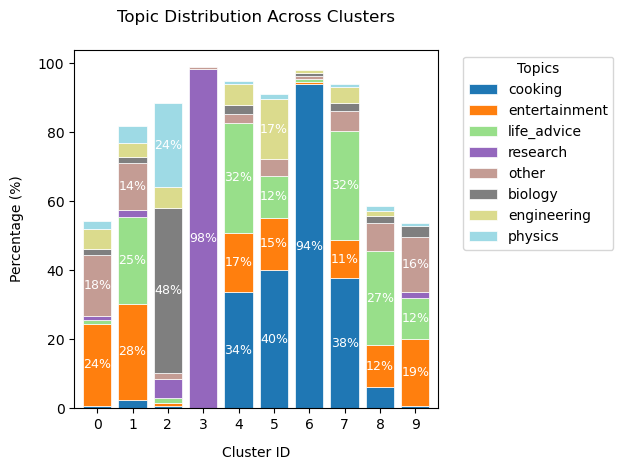

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Create cluster-topic frequency matrix
cluster_topic = pd.crosstab(data['cluster'], data['topic'], normalize='index') * 100

# 2. Print dominant topics per cluster (top 60% cumulative)
print("Dominant Topics per Cluster:")
print("=" * 40)
for cluster in cluster_topic.index:
    # Get sorted topics for this cluster
    topics = cluster_topic.loc[cluster].sort_values(ascending=False)
    
    # Calculate cumulative percentage
    cumsum = topics.cumsum()
    dominant = topics[cumsum <= 60]
    
    # Format output
    topics_str = ", ".join([f"{t} ({p:.1f}%)" for t, p in dominant.items()])
    print(f"Cluster {cluster}: {topics_str}")

# 3. Visualize with stacked bar plot
plt.figure(figsize=(12, 8))

# Get top N topics by overall frequency
top_topics = data['topic'].value_counts().nlargest(8).index
cluster_topic_top = cluster_topic[top_topics]

# Plot
ax = cluster_topic_top.plot.bar(
    stacked=True,
    width=0.8,
    colormap='tab20',
    edgecolor='white',
    linewidth=0.5
)

# Customize
plt.title("Topic Distribution Across Clusters", pad=20)
plt.xlabel("Cluster ID", labelpad=10)
plt.ylabel("Percentage (%)", labelpad=10)
plt.xticks(rotation=0)
plt.legend(
    title="Topics",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

# Add value labels for >10%
for i, cluster in enumerate(cluster_topic_top.index):
    bottom = 0
    for topic in cluster_topic_top.columns:
        val = cluster_topic_top.loc[cluster, topic]
        if val > 10:
            ax.text(
                i, 
                bottom + val/2, 
                f"{val:.0f}%", 
                ha='center',
                va='center',
                color='white',
                fontsize=9
            )
        bottom += val

plt.tight_layout()
plt.show()

### Save the sample

In [ ]:
import json

output_data = []
for _, row in data[data['is_sampled']].iterrows():
    entry = {
        "question_id": str(row.name),
        "category": "brain-hard-v0.1",
        "cluster": row['general_field'],
        "turns": [{
            "content": row['prompt']
        }]
    }
    output_data.append(entry)

with open('../data/brain-hard-v0.1/sampled_questions.jsonl', 'w') as f:
    for entry in output_data:
        f.write(json.dumps(entry) + '\n')

In [6]:
sampled_v2 = pd.read_json('../datasets/final_dataset_filtered-v2.json', lines=False)
sampled_v2 = sampled_v2[sampled_v2['is_sampled']]
sampled_v2.source.value_counts()

source
ybisk/piqa                                 161
allenai/tulu-3-sft-mixture                  80
allenai/ai2_arc                             62
khaimaitien/qa-expert-multi-hop-qa-V1.0     50
allenai/qasper                              35
LongBench/qasper_e                           4
LongBench/multifieldqa_en_e                  3
Name: count, dtype: int64

In [ ]:
sampled_v2.shape.

(395, 20)